# LUCC and habitat fragmentation analysis in a traditional quilombola community as subsidies for conservation policies in Minas Gerais, Brazil

### This notebook explains the methodology used in the article, which involved land use classification using Random Forest, habitat fragmentation analysis, and statistical tests. The work was carried out using Python 3.12 and libraries such as `geopandas`, `rasterio`, `scikit-learn`, `pylandstats`, and `scipy`.

Author: Daniel Fernandes (2024)

## Land Use Classification using Random Forest

### Loading the Data

First, we load the input data and activate the libraries we are going to use. The input files include a multiband raster with our NDVI, NDBI, NDWI, DEM and the bands from Sentinel 2 (4, 3, 2, 8, in that order), and a shapefile with training points for each of the classes we defined. We identified eight different land uses and covers: Forest Formations, Savannah Formations, Grassland Formations, Pastures, Anthropogenic Forests or Forestry, Crops, Exposed Soil and Bodies of Water.

The training points and raster files change for 2018 and 2024, so the model trains with the same set of images, increasing the ability to identify the classes in that scenario. Here I use the example with the 2024 model, but the results are plotted for both years. 

First, we install the necessary libraries. 

In [ ]:
pip install rasterio geopandas numpy pandas fiona scikit-learn pathlib seaborn matplotlib pylandstats openpyxl

In [121]:
import geopandas as gpd
import rasterio as rio
import numpy as np
import pandas as pd
import fiona
import matplotlib
import seaborn
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, cohen_kappa_score

raster_loc = Path('D:/QGIS DOCS/TCC/SENTINEL2A/2024/MOSAICO_SRTM_NDBI_NDVI_NDWI_RGB_B8/MOSAICO_SRTM_NDBI_NDVI_NDWI_RGB_B8.tif')
points_loc = Path('D:/QGIS DOCS/TCC/USO_DE_SOLO/Pontos_treinamento/pontos_treinamento_2024_final_id.shp')

# load the raster and the points

with rio.open(raster_loc) as img:
    bands = img.count
    nodata_value = img.nodata
print('Bands of input image: ', bands)
points = gpd.read_file(points_loc)
points = points.assign(id=range(len(points)))

Bands of input image:  8


### Extract pixel values

We extract the pixel values at the coordinates of the training points. The whole model runs on Sirgas 2000 UTM 23S.


In [93]:
sampled = pd.Series()

with fiona.open(points_loc) as shp:
    for feature in shp:
        point_id = feature['properties']['id']
        coords = feature['geometry']['coordinates']
        with rio.open(raster_loc) as stack_src:
            value = [v for v in stack_src.sample([coords])]
        sampled.loc[point_id] = value

df1 = pd.DataFrame(sampled.values.tolist(), index=sampled.index)
df1['id'] = df1.index
df1 = pd.DataFrame(df1[0].values.tolist(), columns=[f'band{i+1}' for i in range(bands)])
df1['id'] = df1.index

data = pd.merge(df1, points, on='id')
data = data.fillna(0)
data = data.dropna(subset=['labels'])

### Training the Random Forest Model

Here we use the Random Forest algorithm to classify land use. The test size used was 0.3, meaning 30% of the data is used for testing and 70% for training. We used 100 estimators, with the gini criterion. These hyperparameters were close to the standard, but we used grid search previously to identify the best combinations of hyperparameters to train the model which would have the best outcomes. It also calculates accuracy and the kappa score, prints the result and saves the output raster. 

In [99]:
X = data.iloc[:, 0:bands].values
y = data['labels'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

clf = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_leaf=1, min_samples_split=2, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
kappa = cohen_kappa_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Kappa Score: {kappa:.2f}")
print(classification_report(y_test, y_pred))

Accuracy: 94.12%
Kappa Score: 0.93
              precision    recall  f1-score   support

           1       0.90      0.95      0.92        19
           2       0.92      0.92      0.92        13
           3       0.90      0.95      0.92        19
           4       1.00      0.94      0.97        16
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00        13
           7       0.88      0.88      0.88        16
           8       1.00      0.90      0.95        10

    accuracy                           0.94       119
   macro avg       0.95      0.94      0.94       119
weighted avg       0.94      0.94      0.94       119



### Results

**Plot the results in a map!**

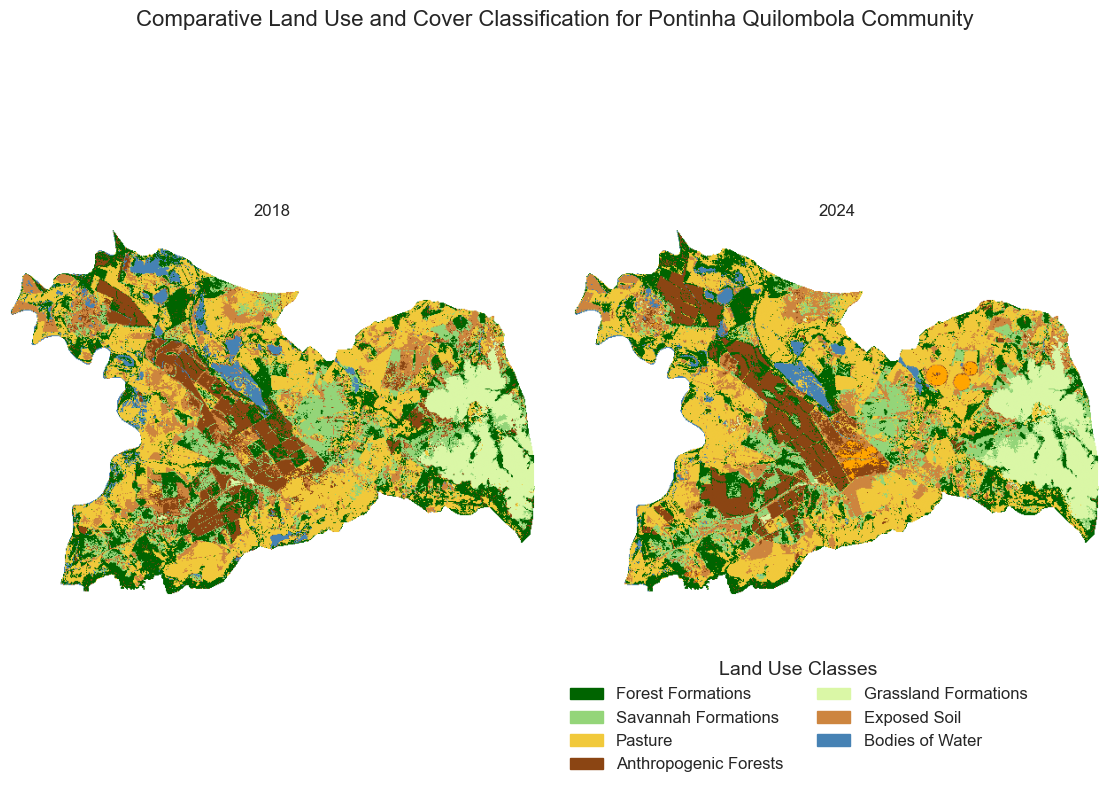

In [135]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import geopandas as gpd
import rasterio as rio
from matplotlib.colors import ListedColormap
from pathlib import Path
from rasterio.mask import mask

shapefile_loc = Path(r'D:\QGIS DOCS\TCC\SICAR\SICAR_GEORREFERENCIADO\Area_do_Imovel\Area_do_Imovel.shp')
raster_2018 = Path(r'D:\QGIS DOCS\TCC\USO_DE_SOLO\USO_DE_SOLO_FINAL\Uso_de_Solo_2018_total.tif')
raster_2024 = Path(r'D:\QGIS DOCS\TCC\USO_DE_SOLO\USO_DE_SOLO_FINAL\Uso_de_Solo_2024_total.tif')

area_of_interest = gpd.read_file(shapefile_loc)

def process_raster(path):
    with rio.open(path) as src:
        nodata_value = src.nodata
        fill_value = nodata_value if nodata_value is not None else 0

        out_image, _ = mask(src, area_of_interest.geometry, crop=True, nodata=fill_value)

        masked_array = np.ma.masked_where(out_image[0] == fill_value, out_image[0], copy=False)

        return masked_array

raster2018 = process_raster(raster_2018)
raster2024 = process_raster(raster_2024)

cmap = ListedColormap([
    '#006400',  # 1. Forest Formations
    '#94D579',  # 2. Savannah Formations
    '#F1C93B',  # 3. Pasture
    '#8B4513',  # 4. Anthropogenic Forests
    '#FFA500',  # 5. Crops (só em 2024)
    '#DAF7A6',  # 6. Grassland Formations
    '#CD853F',  # 7. Exposed Soil
    '#4682B4'   # 8. Bodies of Water
])
cmap.set_bad(color='white')


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11.69, 8.27))

ax1.imshow(raster2018, cmap=cmap, vmin=1, vmax=8)
ax1.set_title('2018', fontsize=12, pad=10)
ax1.axis('off')

ax2.imshow(raster2024, cmap=cmap, vmin=1, vmax=8)
ax2.set_title('2024', fontsize=12, pad=10)
ax2.axis('off')

legend_labels = {
    1: 'Forest Formations',
    2: 'Savannah Formations',
    3: 'Pasture',
    4: 'Anthropogenic Forests',
    6: 'Grassland Formations',  
    7: 'Exposed Soil',
    8: 'Bodies of Water'
}

patches = [mpatches.Patch(color=cmap(i - 1), label=label)
           for i, label in legend_labels.items()]


plt.figlegend(handles=patches,
             title='Land Use Classes',
             loc='lower left',
             ncol=2,
             bbox_to_anchor=(0.5, 0.01),
             frameon=False,
             fontsize=12,
             title_fontsize=14
             )

# Ajustes finais
plt.suptitle('Comparative Land Use and Cover Classification for Pontinha Quilombola Community',
             fontsize=16,
             y=0.95)
plt.tight_layout(pad=3)
plt.show()

### Classification report 

In [122]:
class_labels = {
    1: 'Forest Formations',
    2: 'Savannah Formations',
    3: 'Pasture',
    4: 'Anthropogenic Forests',
    5: 'Crops',
    6: 'Grassland Formations',
    7: 'Exposed Soil',
    8: 'Bodies of Water'
}

Here we can assess the producer and consumer accuracy for each of the classes.

In [123]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

cm_sum = np.sum(cm, axis=1)
cm_diag = np.diag(cm)
cm_sum_pred = np.sum(cm, axis=0)

producer_accuracy = cm_diag / cm_sum
consumer_accuracy = cm_diag / cm_sum_pred

for i, label in enumerate(np.unique(y_test)):
    label_name = class_labels.get(label, str(label))  # Obtém o rótulo da classe ou o número caso não tenha nome
    print(f"Producer Accuracy for class {label_name}: {producer_accuracy[i]:.2f}")
    print(f"Consumer Accuracy for class {label_name}: {consumer_accuracy[i]:.2f}")



Classification Report:
              precision    recall  f1-score   support

           1       0.90      0.95      0.92        19
           2       0.92      0.92      0.92        13
           3       0.90      0.95      0.92        19
           4       1.00      0.94      0.97        16
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00        13
           7       0.88      0.88      0.88        16
           8       1.00      0.90      0.95        10

    accuracy                           0.94       119
   macro avg       0.95      0.94      0.94       119
weighted avg       0.94      0.94      0.94       119

Producer Accuracy for class Forest Formations: 0.95
Consumer Accuracy for class Forest Formations: 0.90
Producer Accuracy for class Savannah Formations: 0.92
Consumer Accuracy for class Savannah Formations: 0.86
Producer Accuracy for class Pasture: 0.89
Consumer Accuracy for class Pasture: 0.94
Producer Accuracy for class An

## Habitat fragmentation analysis

###Loading the Classified Raster

Now, we use the classified raster to calculate fragmentation metrics. Here we use the example of the 2024 raster reclassified for 2 classes: forest and non-forest, 1 and 0, respectively. We calculate all useful class metrics and patch metrics, especially euclidian distance weighted mean for each class. 


In [139]:
import pylandstats as pls
raster_2024_reclass = Path(r'D:\QGIS DOCS\TCC\Fragmentacao\Formacoes_naturais_Total_2024.tif')
landscape = pls.Landscape(raster_2024_reclass)
class_metrics = {
    "Number of patches": landscape.number_of_patches(class_val=1),
    "Mean patch size": landscape.area_mn(class_val=1),
    "Edge density": landscape.edge_density(class_val=1),
    "Euclidean distance area weighted mean": landscape.euclidean_nearest_neighbor_am(class_val=1),
    "Euclidean distance mean": landscape.euclidean_nearest_neighbor_mn(class_val=1)
}

for metric, value in class_metrics.items():
    print(f"{metric}: {value:.2f}")

Number of patches: 1667.00
Mean patch size: 2.30
Edge density: 108.18
Euclidean distance area weighted mean: 61.36
Euclidean distance mean: 76.21


### Fragmentation metrics for different years

In [158]:
import pandas as pd
import pylandstats as pls

input_filepaths = [
    'D:/QGIS DOCS/TCC/Fragmentacao/Formacoes_naturais_Total_2018.tif',
    'D:/QGIS DOCS/TCC/Fragmentacao/Formacoes_naturais_Total_2024.tif'
]

years = ["2018", "2024"]
sta = pls.SpatioTemporalAnalysis(input_filepaths, dates=years)
class_metrics_df = sta.compute_class_metrics_df()

metrics_to_display = [
    'number_of_patches',
    'area_mn',
    'edge_density',
    'euclidean_nearest_neighbor_mn',
    'euclidean_nearest_neighbor_am',
    'total_area' # Include total area
]

results_df = pd.DataFrame(index=years, columns=metrics_to_display)
for year in years:
    for metric in metrics_to_display:
        results_df.loc[year, metric] = class_metrics_df.xs(1, level='class_val').loc[year, metric]

print("Fragmentation Metrics for Natural Formations:")
print(results_df)

[########################################] | 100% Completed | 24.74 s
Fragmentation Metrics for Natural Formations:
     number_of_patches   area_mn edge_density euclidean_nearest_neighbor_mn  \
2018              1862  2.216995   120.499979                     74.208709   
2024              1667  2.295537   108.175816                     76.214184   

     euclidean_nearest_neighbor_am   total_area  
2018                      61.10453  4128.044189  
2024                     61.358607  3826.659637  


## Statistical Test

Now, we perform a statistical test to compare fragmentation metrics between different areas. We use the Mann-Whitney U Test (Wilcoxon Rank-Sum), from scipy.stats, since the data doesn't have normal distribution. The null hypotheses to be tested are as follows: (i) fragmentation did not increase from 2018 to 2024; (ii) fragmentation of the territory occupied by quilombolas is not less than that occupied by outsiders in 2018; (iii) fragmentation of the territory occupied by quilombolas is not less than that occupied by outsiders in 2024. 


We created a sheet for 2018 and 2024, creating columns to separate the part occupied by outsiders and by quilombolas. 

In [155]:
import pandas as pd
from scipy.stats import mannwhitneyu

data2018 = pd.read_excel(r"D:\QGIS DOCS\TCC\Fragmentacao\base_de_dados_patch_metrics_2018.xlsx", sheet_name="2018")
data2024 = pd.read_excel(r"D:\QGIS DOCS\TCC\Fragmentacao\base_de_dados_patch_metrics_2024.xlsx", sheet_name="2024")

# Null Hypothesis 1
stat, p_value_h1 = mannwhitneyu(data2018['euclidean_nearest_neighbor'],
                               data2024['euclidean_nearest_neighbor'],
                               alternative='less')
# Null Hypothesis 2 
stat, p_value_h2 = mannwhitneyu(data2018[data2018['zona'] == 1]['euclidean_nearest_neighbor'],
                               data2018[data2018['zona'] == 2]['euclidean_nearest_neighbor'],
                               alternative='greater')

# Null Hypothesis 3 
stat, p_value_h3 = mannwhitneyu(data2024[data2024['zona'] == 1]['euclidean_nearest_neighbor'],
                               data2024[data2024['zona'] == 2]['euclidean_nearest_neighbor'],
                               alternative='less')


print("Fragmentation increased from 2018 to 2024")
print(f"P-value: {p_value_h1}")
print("Fragmentation of the territory occupied by quilombolas is not less than that occupied by outsiders in 2018")
print(f"P-value: {p_value_h2}")
print("Fragmentation of the territory occupied by quilombolas is not less than that occupied by outsiders in 2024")
print(f"{p_value_h3:.15f}")

Null Hypothesis 1: fragmentation increased from 2018 to 2024
P-value: 0.00023289663297669348
Null Hypothesis 2: fragmentation of the territory occupied by quilombolas is not less than that occupied by outsiders in 2018
P-value: 0.9999999999999813
Null Hypothesis 3:
0.000000000000348
